In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn import metrics
from scipy import interpolate
from tqdm import tqdm
from pathlib import Path
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import copy
from sklearn.decomposition import PCA

In [2]:
# Set up plotting style

sns.set(font_scale=1.5)
sns.set_style('ticks')

colors = ['#88CCEE', '#882255', '#999933', '#332288', '#DDCC77', '#117733','#CC6677', '#44AA99', '#AA4499', '#DDDDDD', '#C70039', '#000000', '#D55E00', '#0072B2']

## Data loading and preprocessing

In [3]:
# Load data and filter for minimum number of occurences
# Returns a dict: extinction name -> pandas data frame

min_occurrence = 3

# Cleaned data - three extinctions
data_base = Path('data_20ext')

# List of characteristics
# It's important to place non-categorical characteristics at the END of this list.
characteristics = ['tiering', 'motility', 'feeding', 'protein', 'reproduction', 'mineralogy', 'physiology', 'geoplates', 'species']
categorical_chars = ['tiering', 'motility', 'feeding', 'protein', 'reproduction', 'mineralogy', 'physiology']

# Loading
events = [x for x in data_base.iterdir() if x.is_file() and x.suffix == '.csv']
datasets = {x.name[:x.name.find('_')]: pd.read_csv(x, encoding="ISO-8859-1") for x in events}

# Filtering for number of occurrences, species and geoplates
datasets = {key: val[val['t_occurrences'] >= min_occurrence] for key, val in datasets.items()}
datasets = {key: val[val['species'] > 0] for key, val in datasets.items()}
datasets = {key: val[val['geoplates'] > 0] for key, val in datasets.items()}

In [4]:
for ext in datasets.keys():
    datasets[ext].dropna(inplace=True)

In [5]:
# Order of the three major extinctions
ext_order = sorted(list(datasets.keys()))
ext_name = {'Cha': 'P/Tr', 
            'Rhe': 'Tr/J',
            'Maa': 'K/Pg',
            'Cen': 'OAE2',
            'Tha': 'PETM'}

In [6]:
# homogenize spelling (capitalization)
for dataset in datasets.values():
    dataset.loc[dataset["mineralogy"] == "High Mg calcite", "mineralogy"] = "high Mg calcite"

In [7]:
# Resamples the data sets to split entries with multiple values into multiple rows with lower weight

def traverse(row, chars, params, weight):
    # Goes over the row recursively and splits if it finds multiple values for one characteristic
    if len(chars) == 0:
        params['weight'] = weight
        return [params]
    else:
        c = chars[0]
        v = row[c]
        if isinstance(v, int) or isinstance(v, float):
            if c not in categorical_chars or v < 10:
                params[c] = v
                return traverse(row, chars[1:], params, weight)
            else:
                res = []
                params1 = copy.deepcopy(params)
                params1[c] = v // 10
                res += traverse(row, chars[1:], params1, weight / 2)
                params2 = copy.deepcopy(params)
                params2[c] = v % 10
                res += traverse(row, chars[1:], params2, weight / 2)
                return res
        else:
            res = []
            parts = v.split('/')
                
            for subv in parts:
                subv = subv.strip()
                subparams = copy.deepcopy(params)
                subparams[c] = subv
                res += traverse(row, chars[1:], subparams, weight / len(parts))
            return res

def rewrite_multi_category(dataset):
    # Iterates over the rows for the traversal
    res = []
    for _, row in dataset.iterrows():
        start_cols = [x for x in dataset.columns if x not in characteristics]
        params = {x: row[x] for x in start_cols}
        
        res += traverse(row, characteristics, params, 1)
    
    return pd.DataFrame(res)

def repeat_rows(dataset):
    # Repeat rows according to the inverse of their weights
    wmin = np.min(dataset['weight'])
    res = []
    for _, row in dataset.iterrows():
        res += int(np.round(row['weight'] / wmin)) * [row]
    return pd.DataFrame(res)

# Run the actual resampling
datasets = {k: rewrite_multi_category(v) for k, v in datasets.items()}

In [8]:
orders = {}

# Fixed orders
orders["tiering"] = ["pelagic", "erect", "epifaunal", "semi-infaunal", "shallow infaunal", "deep infaunal"]
orders["motility"] = ["fast, motile", "slow, motile", "facultative, unattached", "facultative, attached", "stationary, unattached", "stationary, attached"]
orders["feeding"] = ["suspension", "surface deposit", "miner", "grazer", "predator", "symbionts"]
orders["protein"] = ['hemerythrin', 'hemocyanin', 'hemoglobin', 'other']
orders["reproduction"] = ['non-broadcaster', 'intermediate', 'broadcaster']
orders["mineralogy"] = ['aragonite', 'high Mg calcite', 'low Mg calcite', 'bimineralic', 'phosphatic', 'chitin', 'gorgonin', 'silica', 'soft-bodied']
orders["physiology"] = ['heavy carbonate load', 'moderate carbonate load', 'little or no carbonate load']

In [9]:
extinctions = ext_order
n_ext = len(extinctions)

## Model training 

In [10]:
def split_xy(data):
    # Returns numpy matrices of features and labels
    return data[characteristics].values, data['extinct'].values

def prepare_data(dataset, split=True):
    if split:
        # Splits data into training and test with a ratio of 80 : 20.
        # Ensures that all samples from the same base index are in the same split to avoid knowledge leaks.
        # Multiple occurrence of the same sample is a result from the resampling.
        base_idx = np.unique(dataset.index)
        
        splits = np.arange(5).repeat(len(base_idx) // 5 + 1)
        np.random.shuffle(splits)
        splits = splits[:len(base_idx)]
        test_idx = base_idx[splits == 0]

        train_data = dataset[~dataset.index.isin(test_idx)]
        test_data = dataset[dataset.index.isin(test_idx)]

        x_train, y_train = split_xy(train_data)
        x_test, y_test = split_xy(test_data)
    
        return x_train, y_train, x_test, y_test
        
    else:
        return split_xy(dataset)

In [11]:
# Train a catboost model
def train_model(x_train, y_train, x_test, y_test, random_seed=0, **kwargs):
    model = CatBoostClassifier(loss_function="Logloss", random_seed=random_seed)

    # Sets all features a categorical except e_occurrences
    model.fit(x_train, y_train, np.arange(len(categorical_chars)), eval_set=(x_test, y_test), **kwargs)
    
    return model

In [12]:
def run_experiments(iterations=10):
    # Trains models and evaluates feature importance and performance on the different data sets for each iteration
    # The results are stored in the variables res_full (AUC scores) and feat_imp (feature importances)

    res_full = np.zeros((iterations, n_ext, n_ext))
    res_full_train = np.zeros((iterations, n_ext))
    feat_imp = np.zeros((iterations, n_ext, len(characteristics)))

    fpr = dict()
    tpr = dict()
    
    data = None
    model = None
    
    for it in tqdm(range(iterations)):
        res = res_full[it]
        res_train = res_full_train[it]
        
        for i, base in enumerate(extinctions):
            data = prepare_data(datasets[base])
                        
            model = train_model(*data, random_seed=it, plot=False, verbose=False, use_best_model=False)

            feat_imp[it, i] = model.feature_importances_

            x_train, y_train, x_test, y_test = data

            train_auc = metrics.roc_auc_score(y_train, model.predict_log_proba(x_train)[:, 1])
            test_auc = metrics.roc_auc_score(y_test, model.predict_log_proba(x_test)[:, 1])
            res_train[i] = train_auc
            res[i, i] = test_auc
            
            fpr[it, base, base], tpr[it, base, base], _ = metrics.roc_curve(
                y_test, model.predict_log_proba(x_test)[:, 1])

            for j, ext in enumerate(extinctions):
                if ext == base:
                    continue
                dataset = datasets[ext]

                x, y = split_xy(dataset)

                res[i, j] = metrics.roc_auc_score(y, model.predict_log_proba(x)[:, 1])
                fpr[it, base, ext], tpr[it, base, ext], _ = metrics.roc_curve(
                    y, model.predict_log_proba(x)[:, 1])
    
    return res_full, feat_imp, fpr, tpr, res_full_train

In [13]:
res_full_noocc, feat_imp_noocc, fpr_noocc, tpr_noocc, res_train = run_experiments(iterations=10)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:20<00:00, 32.00s/it]


## PCA analysis

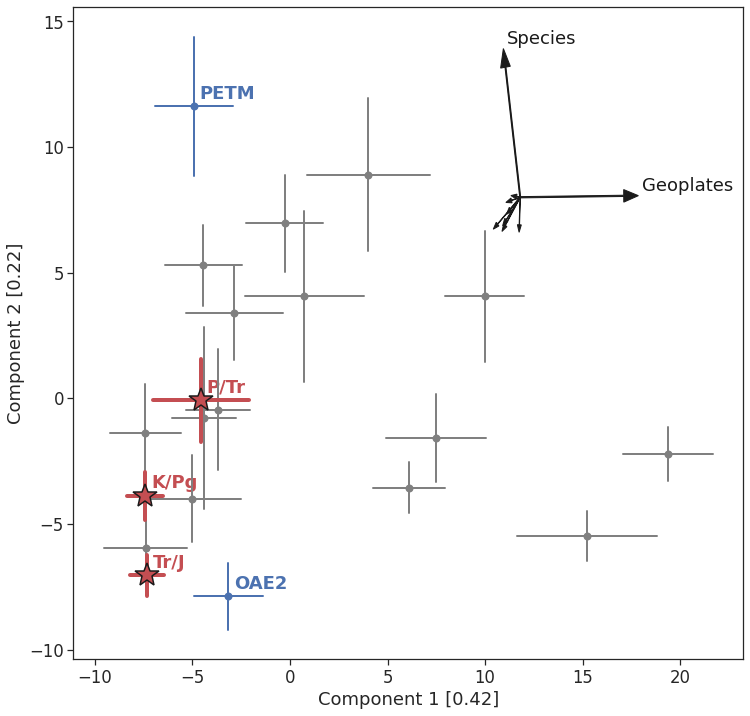

In [38]:
pca = PCA(n_components=2)

x = feat_imp_noocc.reshape((-1,) + feat_imp_noocc.shape[2:])

pca.fit(x)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

for i, ext in enumerate(extinctions):
    trans = pca.transform(feat_imp_noocc[:, i])
    
    marker = 'o'
    ms = 8
    z = 4
    lw = 2
    mew = 0
    mec = 'k'
    
    if ext[:3] in ["Cha", "Rhe", "Maa"]:
        marker = '*'
        ms=25
        c = f"C3"
        z = 10
        lw = 4
        mew = 1.5
    elif ext[:3] in ["Cen", "Tha"]:
        c = "C0"
        z = 5
    else:
        marker = 'o'
        c = "grey"
        
    x_mean = np.mean(trans[:, 0])
    y_mean = np.mean(trans[:, 1])
    x_std = np.std(trans[:, 0])
    y_std = np.std(trans[:, 1])
    
    ax.plot([x_mean - x_std, x_mean + x_std], [y_mean, y_mean], '-', c=c, lw=lw, zorder=z)
    ax.plot([x_mean, x_mean], [y_mean - y_std, y_mean + y_std], '-', c=c, lw=lw, zorder=z)
    ax.plot(x_mean, y_mean, ms=ms, linewidth=0.4, marker=marker, label=ext[:-3], c=c, zorder=z, mew=mew, mec=mec)
    
    if c != "grey":
        ax.text(x_mean + 0.3, y_mean + 0.3 , ext_name[ext[:3]], c=c, weight="bold")
    
var = pca.explained_variance_ratio_
ax.set_xlabel(f"Component 1 [{var[0]:.2f}]")
ax.set_ylabel(f"Component 2 [{var[1]:.2f}]")

root_x = 11.8
root_y = 8
length = 6.5

for i, char in enumerate(characteristics):
    wx = pca.components_[0, i] * length
    wy = pca.components_[1, i] * length
    
    if wx ** 2 + wy ** 2 > (length / 3) ** 2:
        # Only plot sufficiently relevant components
        ax.arrow(root_x, root_y, wx, wy, color='k', width=0.05, head_width=0.5, length_includes_head=True)
        ax.text(root_x + wx + 0.2, root_y + wy + 0.2, char.capitalize(), c='k')
    else:
        ax.arrow(root_x, root_y, wx, wy, color='k', width=0.02, head_width=0.2, length_includes_head=True)
    
fig.savefig("images/pca.png", dpi=300, bbox_inches="tight")